# Experimental reconstruction for "Sample Motion for Structured Illumination Fluorescence Microscopy"

Contact: Ruiming Cao, rcao@berkeley.edu

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib inline
import os
import functools
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import flax
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import calcil as cc

import speckle_flow
from nstm import spacetime
from nstm import utils
from nstm.hash_encoding import HashParameters


### Load data and define parameters

In [2]:
with np.load('experimental_data.npz') as data:
    im_stack = data['im_stack_de_up']
    im_calib = data['im_calib_up']
    timepoints = data['timepoints']
    
binning = 1
bin_factor = [1, 1]
pixel_size = 6.5 * binning
mag = 12.5
RI_medium = 1.0
upsample_factor = 2
dx = pixel_size / mag / upsample_factor

bf_offset_yx = (-7, -4)

dim_yx = (200, 300)
dim_yx_up = (dim_yx[0] * upsample_factor, dim_yx[1] * upsample_factor)
padding_yx = (0, 0)
NA = 0.25
wavelength = 0.605
num_frames = 50
timepoints = np.arange(num_frames) / num_frames

extent = [0, (dim_yx_up[1] + padding_yx[1] * 2) * dx, (dim_yx_up[0] + padding_yx[0] * 2) * dx, 0]
extent_nopad = [0, dim_yx_up[1] * dx, 0, dim_yx_up[0] * dx]

param = utils.SystemParameters(dim_yx_up, wavelength, NA, dx, RI_medium, padding_yx)

### Generate PSF

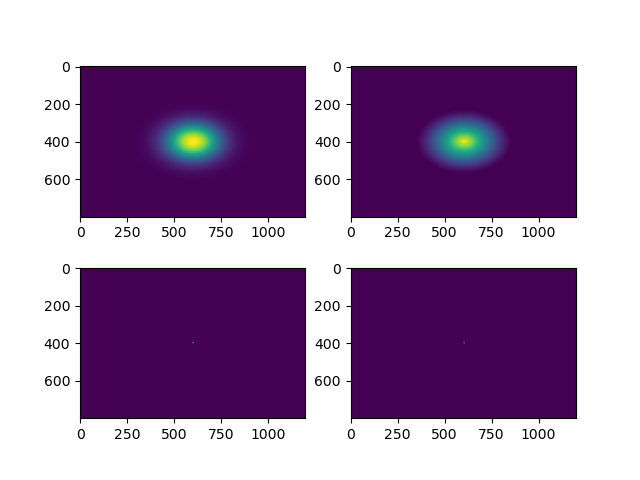

In [3]:
psf = np.abs(utils.psf_gaussian_approx((param.dim_yx[0]*2, param.dim_yx[1]*2), param.pixel_size, param.na, param.wavelength))
OTF = np.fft.fft2(psf)
OTF = OTF / np.max(np.abs(OTF))
pupil = np.asarray(cc.physics.wave_optics.genPupil((param.dim_yx[0]*2, param.dim_yx[1]*2), param.pixel_size, param.na, param.wavelength)).astype(np.complex64)
psf_ = np.abs(np.fft.ifft2(pupil))**2
OTF_ = np.fft.fft2(np.abs(np.fft.ifft2(pupil))**2)
OTF_ = OTF_ / np.max(np.abs(OTF_))

pupil_2na = np.asarray(cc.physics.wave_optics.genPupil((param.dim_yx[0], param.dim_yx[1]), param.pixel_size, param.na * 2, param.wavelength)).astype(np.complex64)
pupil_4na = np.asarray(cc.physics.wave_optics.genPupil((param.dim_yx[0], param.dim_yx[1]), param.pixel_size, param.na * 4, param.wavelength)).astype(np.complex64)

f, axes = plt.subplots(2,2)
axes[0,0].imshow(np.fft.fftshift(np.abs(OTF)))
axes[0,1].imshow(np.fft.fftshift(np.abs(OTF_)))
axes[1,0].imshow(np.fft.fftshift(psf))
axes[1,1].imshow(np.fft.fftshift(psf_))

### Define NSTM parameters

In [4]:
hash_param = HashParameters(bounding_box=(np.array([0, 0]), np.array([param.dim_yx[0]*2, param.dim_yx[1]*2])),
                            n_levels=8, n_features_per_level=2, log2_hashmap_size=16, base_resolution=np.array([param.dim_yx[0]/6, param.dim_yx[1]/6]),
                            finest_resolution=np.array([param.dim_yx[0]/1.5, param.dim_yx[1]/1.5]))

hash_param_motion_space = HashParameters(bounding_box=(np.array([0, 0]), np.array([param.dim_yx[0], param.dim_yx[1]])),
                            n_levels=2, n_features_per_level=2, log2_hashmap_size=16, base_resolution=np.array([1, 1]), finest_resolution=np.array([1, 1]))
hash_param_motion_time = HashParameters(bounding_box=(np.array([-1]), np.array([1])),n_levels=3, n_features_per_level=2, 
                                        log2_hashmap_size=10, base_resolution=1, finest_resolution=4)
motion_embedding_param = {'space': hash_param_motion_space, 'time': hash_param_motion_time}

object_mlp_param = spacetime.MLPParameters(net_depth=2, net_width=128,
                                           net_activation=nn.gelu, skip_layer=4)
motion_mlp_param = spacetime.MLPParameters(net_depth=2, net_width=32, 
                                           net_activation=nn.elu, skip_layer=6)
space_time_param = spacetime.SpaceTimeParameters(motion_mlp_param=motion_mlp_param,
                                                   object_mlp_param=object_mlp_param,
                                                   motion_embedding='hash', motion_embedding_param=motion_embedding_param,
                                                   object_embedding='hash', object_embedding_param=hash_param, 
                                                   out_activation=nn.elu)

### Define dataloader

In [5]:
batch_size = 10 
data_loader = cc.data_utils.loader_from_numpy({'img': im_stack, 't': timepoints}, prefix_dim=(batch_size,), seed=85472, )
sample_input_dict = next(data_loader)[0]

n_imgs: 50, n_batches: 5.


### Init NSTM

In [7]:
rng_key = jax.random.PRNGKey(104)

model = speckle_flow.SpeckleFlowFluo(space_time_param, param, annealed_epoch=4000)  # 500 #2000  # 1500
rng = jax.random.PRNGKey(0)
variables = model.init(rng, input_dict=sample_input_dict)

variables = variables.unfreeze()
variables['params']['I_speckle'] = jnp.asarray(im_calib)
variables['params']['OTF'] = jnp.asarray(OTF)
variables = flax.core.FrozenDict(variables)

### Define optimization objective

In [8]:
l2 = cc.loss.Loss(speckle_flow.gen_loss_l2(10), 'l2')
nonneg_reg = cc.loss.Loss(speckle_flow.gen_loss_nonneg_reg(), 'nonneg_reg', has_intermediates=True)

total_loss = l2 + nonneg_reg * 1e-2

def post_update_projection(state):
    state.params['params']['I_speckle'] = jnp.fft.ifft2(jnp.fft.fft2(state.params['params']['I_speckle']) * pupil_2na).real    
    return state

def output_fn(variables, train_state):
    out = [model.apply(variables, jnp.array([timepoints[t]]), method=lambda module, a: module.spacetime(a, np.zeros((1,2)))[0,..., 0])[10:-10,10:-10] for t in jnp.arange(0, num_frames, num_frames-1)]
    return {'recon_fluo': out, 'I_speckle': variables['params']['I_speckle'], 
            'pupil_aber_amp': jnp.abs(variables['params']['OTF']) }

### Run optimization

In [ ]:
n_epoch = 5000
save_dir = './checkpoints/experiment_fluo/'
recon_param = cc.reconstruction.ReconIterParameters(save_dir=save_dir, n_epoch=n_epoch, keep_checkpoints=10, checkpoint_every=10000,
                                                 output_every=100, log_every=20,)

no_update_params = cc.reconstruction.ReconVarParameters(lr=0)
spacetime_mlp_params = cc.reconstruction.ReconVarParameters(lr=1e-4, opt='adam', opt_kwargs={'b1': 0.9, 'b2': 0.99, 'eps': 1e-15},
                                                            schedule='exponential', schedule_kwargs={'transition_steps':5e3, 'decay_rate': 0.8, 'transition_begin': 0},
                                                            update_every=1)
motion_mlp_params = cc.reconstruction.ReconVarParameters(lr=1e-4, opt='adam', opt_kwargs={'b1': 0.9, 'b2': 0.99, 'eps': 1e-15}, 
                                                         schedule='exponential', schedule_kwargs={'transition_steps':1e4, 'decay_rate': 0.8, 'transition_begin': 0},
                                                         update_every=1)
speckle_I_params = cc.reconstruction.ReconVarParameters(lr=1e-4, opt='adam', schedule='exponential', #5e-5 # 1e-6
                                                        schedule_kwargs={'transition_steps':5e5, 'decay_rate': 0.1}, update_every=5, # 5
                                                        delay_update_n_iter=0)

var_params = {'params': {'spacetime': {'object_mlp': spacetime_mlp_params, 'motion_mlp': motion_mlp_params, 'motion_embedding': motion_mlp_params, 'object_embedding': spacetime_mlp_params}, 
                         'I_speckle': speckle_I_params, 'OTF': no_update_params, }}

recon_variables, recon = cc.reconstruction.reconstruct_multivars_sgd(model.apply, variables, var_params, data_loader, total_loss, recon_param, output_fn, post_update_projection)

recon_t = [model.apply(recon_variables, jnp.array([timepoints[t]]), method=lambda module, a: module.spacetime(a, np.zeros((1,2)))[0])[..., 0] for t in jnp.arange(num_frames)]
recon_t = np.abs(np.fft.ifft2(np.fft.fft2(np.array(recon_t)) * pupil_4na))

epoch: 20, l2: 0.00065645, nonneg_reg: 0.0000, total_loss: 0.00065645, epoch per sec: 1.5240
epoch: 40, l2: 0.00065439, nonneg_reg: 0.0000, total_loss: 0.00065439, epoch per sec: 1.7783
epoch: 60, l2: 0.00065075, nonneg_reg: 0.0000, total_loss: 0.00065075, epoch per sec: 1.7764
epoch: 80, l2: 0.00063999, nonneg_reg: 0.0000, total_loss: 0.00063999, epoch per sec: 1.7728
epoch: 100, l2: 0.00061690, nonneg_reg: 0.0000, total_loss: 0.00061690, epoch per sec: 1.7710
epoch: 120, l2: 0.00059993, nonneg_reg: 4.6552e-08, total_loss: 0.00059997, epoch per sec: 1.7732
epoch: 140, l2: 0.00059393, nonneg_reg: 1.9464e-08, total_loss: 0.00059395, epoch per sec: 1.7718
epoch: 160, l2: 0.00058685, nonneg_reg: 1.8894e-07, total_loss: 0.00058704, epoch per sec: 1.7709
epoch: 180, l2: 0.00057984, nonneg_reg: 1.2310e-07, total_loss: 0.00057996, epoch per sec: 1.7701
epoch: 200, l2: 0.00057167, nonneg_reg: 2.5516e-07, total_loss: 0.00057192, epoch per sec: 1.7694
epoch: 220, l2: 0.00056242, nonneg_reg: 2.79

### Visualize reconstruction

interactive(children=(IntSlider(value=0, description='t', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrame_t(t)>

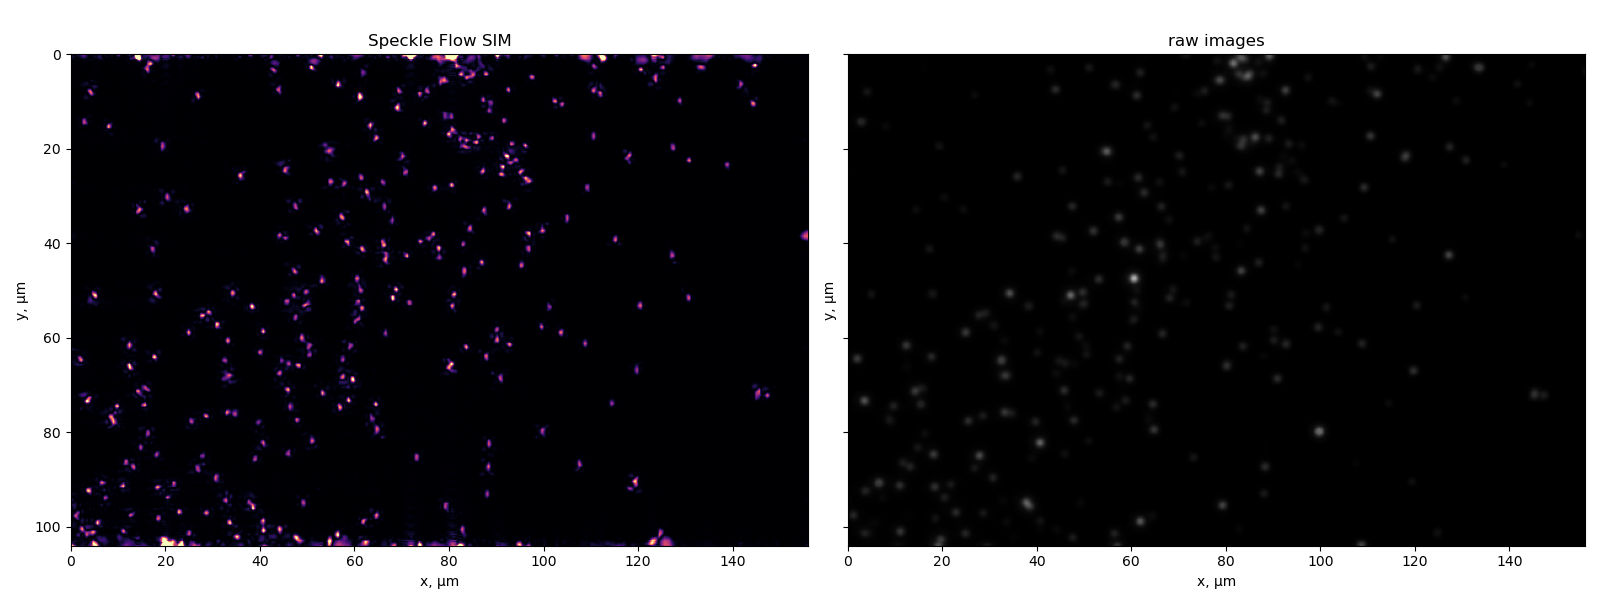

In [12]:
f_t, ax_t = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
frame_t = []

def init_t():
    frame_t.append(ax_t[0].imshow(recon_t[0], clim=(0,5), cmap='magma', extent=extent))
    frame_t.append(ax_t[1].imshow(im_stack[0], clim=(0,1), cmap='gray', extent=extent))

    ax_t[0].set_title('Speckle Flow SIM')
    ax_t[1].set_title('raw images')

    ax_t[0].set_xlabel('x, µm')
    ax_t[0].set_ylabel('y, µm')
    ax_t[1].set_xlabel('x, µm')
    ax_t[1].set_ylabel('y, µm')
    f_t.tight_layout()
    
init_t()
def updateFrame_t(t):
    frame_t[0].set_data(recon_t[t])
    frame_t[1].set_data(im_stack[t])

interact(updateFrame_t, t=IntSlider(min=0, max=len(recon_t)-1, step=1, value=0))